### Notebook for the label transfer of WT mice to genotypes with `scANVI`

- **Developed by:** Carlos Talavera-López Ph.D
- **Würzburg Institute for Systems Immunology - Faculty of Medicine - Julius-Maximilian-Universität Würzburg**
- v230829

### Import required modules

In [1]:
import scvi
import torch
import anndata
import warnings
import numpy as np
import scanpy as sc
import pandas as pd
import plotnine as p
import matplotlib.pyplot as plt
from scib_metrics.benchmark import Benchmarker

/home/ruth/mambaforge/envs/scvi-tools/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/ruth/mambaforge/envs/scvi-tools/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


### Set up working environment

In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.9.2
scanpy      1.9.4
-----
PIL                 10.0.0
absl                NA
aiohttp             3.8.5
aiosignal           1.3.1
annotated_types     0.5.0
anyio               NA
asttokens           NA
async_timeout       4.0.3
attr                23.1.0
backcall            0.2.0
backoff             2.2.1
bs4                 4.12.2
certifi             2023.07.22
charset_normalizer  3.2.0
chex                0.1.7
click               8.1.7
comm                0.1.4
contextlib2         NA
croniter            NA
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.7.post1
decorator           5.1.1
deepdiff            6.3.1
docrep              0.3.2
etils               1.4.1
executing           1.2.0
fastapi             0.103.0
flax                0.7.2
frozenlist          1.4.0
fsspec              2023.6.0
h5py                3.9.0
idna                3.4
importlib_resources NA
ipykernel           6.25.1
ipywidgets        

In [3]:
warnings.simplefilter(action = 'ignore')
scvi.settings.seed = 1712
%config InlineBackend.print_figure_kwargs = {'facecolor' : "w"}
%config InlineBackend.figure_format = 'retina'
torch.set_float32_matmul_precision('medium')

Global seed set to 1712


In [4]:
arches_params = dict(
    use_layer_norm = "both",
    use_batch_norm = "none",
    encode_covariates = True,
    dropout_rate = 0.2,
    n_layers = 3,
)

### Read in data

In [5]:
heart_scANVI = sc.read_h5ad('../data/heart_mm_nuclei-23-0092_scANVI-CellStates_ctl230918.raw.h5ad')
heart_scANVI

AnnData object with n_obs × n_vars = 143257 × 32285
    obs: 'cell_source', 'cell_type', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'cell_states', 'seed_labels', 'genotype', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [6]:
heart_scANVI.obs_names = [name.rsplit('-', 1)[0] for name in heart_scANVI.obs_names]
heart_scANVI.obs_names

Index(['ACAACCATCCTTATCA-1-A9_2-A9_2', 'ATTCGTTCAAGTGGAC-1-A9_2-A9_2',
       'TCACATTGTCTCCTGT-1-A9_2-A9_2', 'CTCAACCAGATCCAAA-1-A9_2-A9_2',
       'CGGCAGTGTGGCCTCA-1-A9_2-A9_2', 'CCTTCAGGTCCTTGTC-1-A9_2-A9_2',
       'TATCGCCAGCATTTGC-1-A9_2-A9_2', 'CACCAAAAGCACTAAA-1-A9_2-A9_2',
       'TTTGGAGCACCAGGTC-1-A9_2-A9_2', 'TACCCACAGTCTTGGT-1-A9_2-A9_2',
       ...
       'GGGAGTACACTACGGC-1-B2_2-B2_2', 'TTGCGTCGTGAGCCAA-1-B2_2-B2_2',
       'CCTCAACTCTAGTGAC-1-B2_2-B2_2', 'CATTGTTAGTCTACCA-1-B2_2-B2_2',
       'CATTCTATCATAGGCT-1-B2_2-B2_2', 'TCAGTTTAGGGAACAA-1-B2_2-B2_2',
       'GCAACCGTCTAACGCA-1-B2_2-B2_2', 'AGAGAGCGTCGCAGTC-1-B2_2-B2_2',
       'GTCAAACCATTGACAC-1-B2_2-B2_2', 'GATTTCTTCGCAGTGC-1-B2_2-B2_2'],
      dtype='object', length=143257)

In [7]:
heart_scANVI.obs['seed_labels'] = heart_scANVI.obs['C_scANVI'].copy()
del(heart_scANVI.obs['C_scANVI'])
heart_scANVI

AnnData object with n_obs × n_vars = 143257 × 32285
    obs: 'cell_source', 'cell_type', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'cell_states', 'seed_labels', 'genotype', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [8]:
heart_scANVI.obs['seed_labels'].value_counts()

seed_labels
PC3_str       81764
EC1_cap       13721
EC3_cap       10315
vCM1           8504
FB1            5857
DOCK4+vMØ      5354
FB2            4471
PC1_vent       3052
EC6_ven        3029
EC5_art        2750
EC7_atria      2333
nøMo            666
NK_CD16hi       609
SMC1_basic      410
Mast            385
aCM1             34
Adip1             3
Name: count, dtype: int64

### Read in other unannotated dataset and split into groups

In [9]:
heart_scANVI.obs['genotype'].value_counts()

genotype
WT         62352
MdxSCID    57952
Mdx        22953
Name: count, dtype: int64

In [10]:
reference = heart_scANVI[heart_scANVI.obs['genotype'].isin(['WT', 'Mdx'])]
reference

View of AnnData object with n_obs × n_vars = 85305 × 32285
    obs: 'cell_source', 'cell_type', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'cell_states', 'seed_labels', 'genotype', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [11]:
query = heart_scANVI[~heart_scANVI.obs['genotype'].isin(['WT', 'Mdx'])]
query.obs['seed_labels'] = 'Unknown'
query

AnnData object with n_obs × n_vars = 57952 × 32285
    obs: 'cell_source', 'cell_type', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'cell_states', 'seed_labels', 'genotype', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [12]:
adata = reference.concatenate(query, batch_key = 'batch', batch_categories = ['reference', 'query'], join = 'inner')
adata

AnnData object with n_obs × n_vars = 143257 × 32285
    obs: 'cell_source', 'cell_type', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'cell_states', 'seed_labels', 'genotype', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

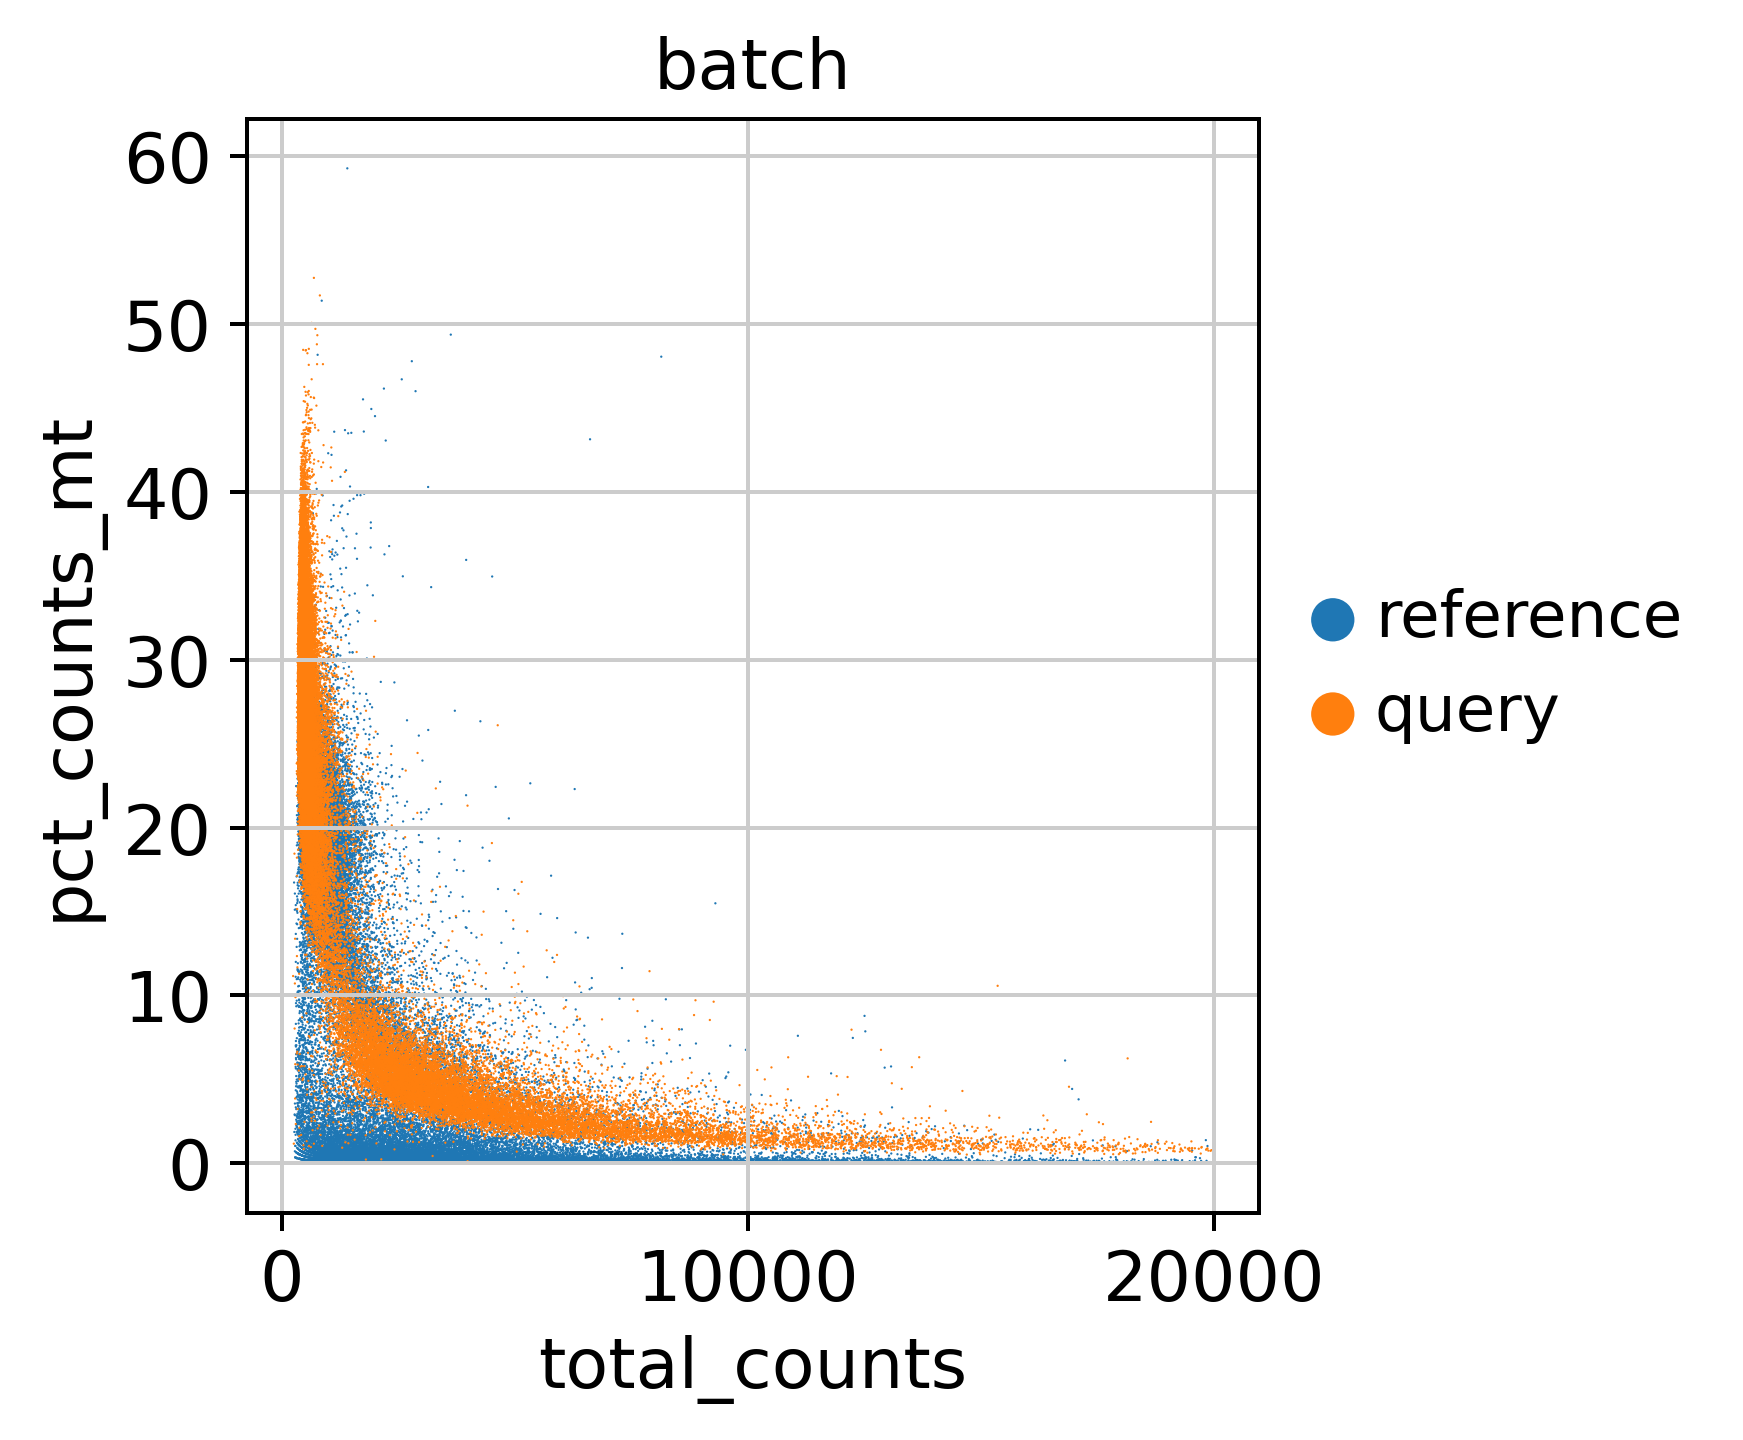

In [13]:
sc.pl.scatter(adata, x = 'total_counts', y = 'pct_counts_mt', color = "batch", frameon = False)

In [14]:
adata.obs['genotype'].value_counts()

genotype
WT         62352
MdxSCID    57952
Mdx        22953
Name: count, dtype: int64

In [15]:
adata.obs['sample'].value_counts()

sample
A10_2    57604
B1_2     44760
B2_2     13192
A11_2    13168
A12_2     9785
A9_2      4748
Name: count, dtype: int64

### Select HVGs

In [16]:
adata_raw = adata.copy()
adata.layers['counts'] = adata.X.copy()

sc.pp.highly_variable_genes(
    adata,
    flavor = "seurat_v3",
    n_top_genes = 3000,
    layer = "counts",
    batch_key = "sample",
    subset = True
)
adata

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


AnnData object with n_obs × n_vars = 143257 × 3000
    obs: 'cell_source', 'cell_type', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'cell_states', 'seed_labels', 'genotype', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'batch_colors', 'hvg'
    layers: 'counts'

### Transfer of annotation with scANVI

In [17]:
scvi.model.SCVI.setup_anndata(adata,
                              batch_key = "sample", 
                            categorical_covariate_keys = ["sample"], 
                            labels_key = "seed_labels", 
                            layer = 'counts')

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [18]:
scvi_model = scvi.model.SCVI(adata, n_latent = 50, n_layers = 3, dispersion = 'gene-batch', gene_likelihood = 'nb')

In [19]:
scvi_model.train(60, check_val_every_n_epoch = 1, enable_progress_bar = True, use_gpu = 1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 60/60: 100%|██████████| 60/60 [05:24<00:00,  4.55s/it, v_num=1, train_loss_step=902, train_loss_epoch=859]      

`Trainer.fit` stopped: `max_epochs=60` reached.


Epoch 60/60: 100%|██████████| 60/60 [05:24<00:00,  5.41s/it, v_num=1, train_loss_step=902, train_loss_epoch=859]


In [20]:
adata.obsm["X_scVI"] = scvi_model.get_latent_representation(adata)

### Evaluate model performance using the [_Svensson_](https://www.nxn.se/valent/2023/8/10/training-scvi-posterior-predictive-distributions-over-epochs) method

In [ ]:
history_df = (
    scvi_model.history['elbo_train'].astype(float)
    .join(scvi_model.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 6, 3

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.theme_minimal()
)

p_.save('fig1.png', dpi = 300)

print(p_)

### Label transfer with `scANVI` 

In [21]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(scvi_model, 'Unknown')

In [22]:
scanvi_model.train(60, check_val_every_n_epoch = 1, enable_progress_bar = True, use_gpu = 1)

INFO     Training for 60 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 30/60:  48%|████▊     | 29/60 [06:17<08:37, 16.69s/it, v_num=1, train_loss_step=999, train_loss_epoch=951]    

In [ ]:
adata.obs["C_scANVI"] = scanvi_model.predict(adata)

- Extract latent representation

In [ ]:
adata.obsm["X_scANVI"] = scanvi_model.get_latent_representation(adata)

### Explore model performance using the [_Svensson_](https://www.nxn.se/valent/2023/8/10/training-scvi-posterior-predictive-distributions-over-epochs) method

In [ ]:
history_df = (
    scanvi_model.history['elbo_train'].astype(float)
    .join(scanvi_model.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 6, 3

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.theme_minimal()
)

p_.save('fig1.png', dpi = 300)

print(p_)

- Visualise corrected dataset

In [ ]:
sc.pp.neighbors(adata, use_rep = "X_scANVI", n_neighbors = 50, metric = 'minkowski')
sc.tl.umap(adata, min_dist = 0.3, spread = 4, random_state = 1712)
sc.pl.umap(adata, frameon = False, color = ['sample', 'genotype', 'C_scANVI', 'seed_labels'], size = 0.6, legend_fontsize = 5, ncols = 4)

In [ ]:
sc.pl.umap(adata, frameon = False, color = ['n_genes', 'doublet_scores', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_counts'], size = 0.6, legend_fontsize = 5, ncols = 4, cmap = 'plasma')

### Modify object to plot canonical marker genes

In [ ]:
adata_toplot = anndata.AnnData(X = np.sqrt(sc.pp.normalize_total(adata_raw, inplace = False)["X"]), var = adata_raw.var, obs = adata.obs, obsm = adata.obsm)
adata_toplot

In [ ]:
sc.pl.umap(adata_toplot, frameon = False, color = ['C_scANVI', 'Ttn', 'Nppa', 'Dcn', 'Vwf', 'Myh11', 'Rgs4', 'Kcnj8', 'C1qa', 'Cd3e', 'Trem2', 'Adipoq', 'Nrxn1', 'Msln'], size = 0.6, legend_fontsize = 5, ncols = 4, cmap = 'magma')

### Compute integration metrics

In [ ]:
bm.plot_results_table(min_max_scale = False)

### Export annotated sample object 

In [ ]:
adata.obs.index = pd.Index(['-'.join(idx.split('-')[:3]) for idx in adata.obs.index])
adata.obs.index

In [ ]:
adata_raw.obs.index = pd.Index(['-'.join(idx.split('-')[:3]) for idx in adata_raw.obs.index])
adata_raw.obs.index

In [ ]:
adata.obs_names

In [ ]:
adata.obs['C_scANVI'].cat.categories

In [ ]:
adata.obs['C_scANVI'].value_counts()

### Export annotated object with raw counts

In [ ]:
adata

In [ ]:
adata_raw

In [ ]:
adata_export = anndata.AnnData(X = adata_raw.X, obs = adata.obs, var = adata_raw.var)
adata_export.obsm['X_scVI'] = adata.obsm['X_scVI'].copy()
adata_export.obsm['X_umap'] = adata.obsm['X_umap'].copy()
adata_export.obsm['X_scANVI'] = adata.obsm['X_scANVI'].copy()
adata_export